In [1]:
import numpy as np
import pandas as pd
import random
import cv2
import os

from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score, recall_score, average_precision_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv("Main_data_shuffled.csv")

In [3]:
dataset

,velocity_x,velocity_y,constant_offset_check,total_displacement,attacktype
0,-3.362600,29.137000,29.330000,0.000,5
1,10.013000,0.621020,10.033000,0.000,1
2,0.283390,0.018390,0.283990,217.200,0
3,0.049947,-0.006131,0.050322,86.691,0
4,0.119970,1.070000,1.076700,183.390,0
...,...,...,...,...,...
105315,-0.641980,-3.922200,3.974400,130.490,0
105316,-0.056932,0.214690,0.222120,68.672,2
105317,0.119940,-0.011851,0.120530,364.230,2
105318,0.276000,-0.191970,0.336190,69.873,0


In [4]:
dataset.attacktype.unique()

array([5, 1, 0, 3, 2, 4], dtype=int64)

In [5]:
X = dataset.iloc[:,:4].values
y = dataset.iloc[:,4:5].values

In [6]:
#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [7]:
lb = LabelBinarizer()
y = lb.fit_transform(y)

In [8]:
y

array([[0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 105)

In [10]:
X_train

array([[ 4.04991904e-02,  1.21374985e-01,  1.55469589e-02,
        -4.94288635e-01],
       [ 6.52819504e-03,  7.76554288e-03, -6.48916638e-02,
        -7.57844721e-02],
       [ 3.87540944e-04,  2.03596706e-03, -7.08437763e-02,
         4.14351338e-01],
       ...,
       [-1.14980062e-03,  2.86515429e-03, -7.06745492e-02,
        -2.28020375e-01],
       [ 5.79182629e-03, -1.32359021e-03, -6.73954527e-02,
         3.65906706e-01],
       [ 1.24967792e-03,  1.80492463e-04, -7.08276624e-02,
        -8.90848273e-02]])

In [11]:
def create_clients(X, y, num_clients=10, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(X, y))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 

In [12]:
#create clients
clients = create_clients(X_train, y_train, num_clients=10, initial='client')

In [13]:
def batch_data(data_shard, bs=16):
    '''Takes in a clients data shard and create a tfds object of it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [14]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    # print("aashma")
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [15]:
print(clients_batched['client_1'])

<BatchDataset shapes: ((None, 4), (None, 6)), types: (tf.float64, tf.int32)>


In [16]:
class SimpleMLP:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,) , activation='relu'))
        model.add(Dense(200, activation = 'relu'))
        model.add(Dense(6, activation='softmax'))
        return model

In [17]:
lr = 0.01 
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(lr=lr, 
                decay=lr / 10,
                momentum = 0.9
               )    

In [18]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count

In [19]:
def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final

In [20]:
def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad

In [21]:
def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('Communication Round: {} | acc: {:.3%} | loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [22]:
#initialize global model
smlp_global = SimpleMLP()
global_model = smlp_global.build(4, 6)

global_acc_list = []
global_precision_list = []
global_recall_list = []

comms_round = 500

#commence global training loop
for comm_round in range(comms_round):
    
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(4, 6)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)

        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)
    
    model_json = global_model.to_json()
    with open("global_model_edit.json", "w") as json_file:
        json_file.write(model_json)
    
    # serialize weights to HDF5
    global_model.save_weights("model_edit.h5")

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_acc_list.append(global_acc)
        
        y_pred = global_model.predict(X_test)
        
        global_precision = precision_score(tf.argmax(Y_test, axis=1), tf.argmax(y_pred, axis=1), average='weighted', labels = [0,1,2,3,4,5])
        global_precision_list.append(global_precision)
        
        global_recall = recall_score(tf.argmax(Y_test, axis=1), tf.argmax(y_pred, axis=1), average='weighted', labels = [0,1,2,3,4,5])
        global_recall_list.append(global_recall)

Communication Round: 0 | acc: 73.234% | loss: 1.4085750579833984


C:\Users\Intelligence\anaconda3\envs\federated\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Communication Round: 1 | acc: 73.709% | loss: 1.4025026559829712
Communication Round: 2 | acc: 73.927% | loss: 1.3973124027252197
Communication Round: 3 | acc: 74.592% | loss: 1.392206072807312
Communication Round: 4 | acc: 75.190% | loss: 1.3860613107681274
Communication Round: 5 | acc: 75.807% | loss: 1.3832200765609741
Communication Round: 6 | acc: 76.111% | loss: 1.379767656326294
Communication Round: 7 | acc: 76.092% | loss: 1.3782274723052979
Communication Round: 8 | acc: 76.149% | loss: 1.376281976699829
Communication Round: 9 | acc: 76.282% | loss: 1.373458981513977
Communication Round: 10 | acc: 76.348% | loss: 1.3720759153366089
Communication Round: 11 | acc: 76.434% | loss: 1.3717795610427856
Communication Round: 12 | acc: 76.500% | loss: 1.370177984237671
Communication Round: 13 | acc: 76.557% | loss: 1.3686633110046387
Communication Round: 14 | acc: 76.643% | loss: 1.3687684535980225
Communication Round: 15 | acc: 76.700% | loss: 1.3664753437042236
Communication Round: 16 

Communication Round: 126 | acc: 78.760% | loss: 1.34271240234375
Communication Round: 127 | acc: 78.750% | loss: 1.3425605297088623
Communication Round: 128 | acc: 78.798% | loss: 1.3425278663635254
Communication Round: 129 | acc: 78.779% | loss: 1.3423418998718262
Communication Round: 130 | acc: 78.817% | loss: 1.3423405885696411
Communication Round: 131 | acc: 78.817% | loss: 1.3422836065292358
Communication Round: 132 | acc: 78.817% | loss: 1.3421599864959717
Communication Round: 133 | acc: 78.826% | loss: 1.3422081470489502
Communication Round: 134 | acc: 78.826% | loss: 1.3421002626419067
Communication Round: 135 | acc: 78.826% | loss: 1.3419970273971558
Communication Round: 136 | acc: 78.817% | loss: 1.3419904708862305
Communication Round: 137 | acc: 78.826% | loss: 1.3419266939163208
Communication Round: 138 | acc: 78.826% | loss: 1.341858148574829
Communication Round: 139 | acc: 78.836% | loss: 1.3417487144470215
Communication Round: 140 | acc: 78.845% | loss: 1.341763019561767

Communication Round: 249 | acc: 79.311% | loss: 1.336977243423462
Communication Round: 250 | acc: 79.330% | loss: 1.3369064331054688
Communication Round: 251 | acc: 79.330% | loss: 1.3369340896606445
Communication Round: 252 | acc: 79.339% | loss: 1.3369014263153076
Communication Round: 253 | acc: 79.368% | loss: 1.3368866443634033
Communication Round: 254 | acc: 79.368% | loss: 1.3368419408798218
Communication Round: 255 | acc: 79.368% | loss: 1.3368042707443237
Communication Round: 256 | acc: 79.368% | loss: 1.336745023727417
Communication Round: 257 | acc: 79.377% | loss: 1.3367570638656616
Communication Round: 258 | acc: 79.368% | loss: 1.3367232084274292
Communication Round: 259 | acc: 79.377% | loss: 1.3366820812225342
Communication Round: 260 | acc: 79.377% | loss: 1.3366998434066772
Communication Round: 261 | acc: 79.377% | loss: 1.3366835117340088
Communication Round: 262 | acc: 79.396% | loss: 1.33665132522583
Communication Round: 263 | acc: 79.396% | loss: 1.3366020917892456

Communication Round: 372 | acc: 79.567% | loss: 1.3341188430786133
Communication Round: 373 | acc: 79.567% | loss: 1.3340919017791748
Communication Round: 374 | acc: 79.567% | loss: 1.3340637683868408
Communication Round: 375 | acc: 79.586% | loss: 1.3340708017349243
Communication Round: 376 | acc: 79.586% | loss: 1.3340481519699097
Communication Round: 377 | acc: 79.586% | loss: 1.3340325355529785
Communication Round: 378 | acc: 79.586% | loss: 1.3340238332748413
Communication Round: 379 | acc: 79.586% | loss: 1.3340197801589966
Communication Round: 380 | acc: 79.605% | loss: 1.3339923620224
Communication Round: 381 | acc: 79.605% | loss: 1.3339794874191284
Communication Round: 382 | acc: 79.605% | loss: 1.3339591026306152
Communication Round: 383 | acc: 79.615% | loss: 1.333923101425171
Communication Round: 384 | acc: 79.615% | loss: 1.333907961845398
Communication Round: 385 | acc: 79.615% | loss: 1.333878993988037
Communication Round: 386 | acc: 79.615% | loss: 1.3338545560836792
C

Communication Round: 495 | acc: 79.795% | loss: 1.3321797847747803
Communication Round: 496 | acc: 79.795% | loss: 1.332177758216858
Communication Round: 497 | acc: 79.795% | loss: 1.3321583271026611
Communication Round: 498 | acc: 79.795% | loss: 1.3321517705917358
Communication Round: 499 | acc: 79.795% | loss: 1.332140326499939


In [23]:
sgd_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(16)
smlp_sgd = SimpleMLP()
sgd_model = smlp_sgd.build(4, 6) 

sgd_acc_list = []
sgd_precision_list = []
sgd_recall_list = []

sgd_model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metrics)

# fit the SGD training data to model
for i in range(500):

    sgd_model.fit(X_train, y_train, epochs=1, verbose=0)
    for(X_test, Y_test) in test_batched:
        sgd_acc, sgd_loss = test_model(X_test, Y_test, sgd_model, i)
        sgd_acc_list.append(sgd_acc)
        
        y_pred = sgd_model.predict(X_test)
        
        sgd_precision = precision_score(tf.argmax(Y_test, axis=1), tf.argmax(y_pred, axis=1), average='weighted', labels = [0,1,2,3,4,5])
        sgd_precision_list.append(sgd_precision)
        
        sgd_recall = recall_score(tf.argmax(Y_test, axis=1), tf.argmax(y_pred, axis=1), average='weighted', labels = [0,1,2,3,4,5])
        sgd_recall_list.append(sgd_recall)

Communication Round: 0 | acc: 68.487% | loss: 1.781839370727539
Communication Round: 1 | acc: 72.294% | loss: 1.7688783407211304
Communication Round: 2 | acc: 72.455% | loss: 1.7550967931747437
Communication Round: 3 | acc: 72.436% | loss: 1.7406315803527832
Communication Round: 4 | acc: 72.408% | loss: 1.7254524230957031
Communication Round: 5 | acc: 72.389% | loss: 1.7096189260482788
Communication Round: 6 | acc: 72.370% | loss: 1.6932495832443237
Communication Round: 7 | acc: 72.351% | loss: 1.6764763593673706
Communication Round: 8 | acc: 72.341% | loss: 1.6594243049621582
Communication Round: 9 | acc: 72.322% | loss: 1.6424442529678345
Communication Round: 10 | acc: 72.322% | loss: 1.6257280111312866
Communication Round: 11 | acc: 72.322% | loss: 1.6095802783966064
Communication Round: 12 | acc: 72.322% | loss: 1.5941741466522217
Communication Round: 13 | acc: 72.322% | loss: 1.5796525478363037
Communication Round: 14 | acc: 72.322% | loss: 1.5661455392837524
Communication Round: 

Communication Round: 125 | acc: 72.854% | loss: 1.4294193983078003
Communication Round: 126 | acc: 72.854% | loss: 1.4292285442352295
Communication Round: 127 | acc: 72.854% | loss: 1.4290590286254883
Communication Round: 128 | acc: 72.873% | loss: 1.4288994073867798
Communication Round: 129 | acc: 72.883% | loss: 1.4287166595458984
Communication Round: 130 | acc: 72.883% | loss: 1.42853581905365
Communication Round: 131 | acc: 72.892% | loss: 1.428376317024231
Communication Round: 132 | acc: 72.892% | loss: 1.4282113313674927
Communication Round: 133 | acc: 72.892% | loss: 1.4280338287353516
Communication Round: 134 | acc: 72.902% | loss: 1.4278662204742432
Communication Round: 135 | acc: 72.902% | loss: 1.427701711654663
Communication Round: 136 | acc: 72.911% | loss: 1.4275286197662354
Communication Round: 137 | acc: 72.911% | loss: 1.4273347854614258
Communication Round: 138 | acc: 72.930% | loss: 1.4271637201309204
Communication Round: 139 | acc: 72.930% | loss: 1.4270061254501343

Communication Round: 248 | acc: 73.519% | loss: 1.4082120656967163
Communication Round: 249 | acc: 73.519% | loss: 1.407985806465149
Communication Round: 250 | acc: 73.519% | loss: 1.4078222513198853
Communication Round: 251 | acc: 73.528% | loss: 1.4076461791992188
Communication Round: 252 | acc: 73.538% | loss: 1.4074825048446655
Communication Round: 253 | acc: 73.538% | loss: 1.4073314666748047
Communication Round: 254 | acc: 73.538% | loss: 1.4071334600448608
Communication Round: 255 | acc: 73.557% | loss: 1.406991958618164
Communication Round: 256 | acc: 73.557% | loss: 1.406795620918274
Communication Round: 257 | acc: 73.566% | loss: 1.406650424003601
Communication Round: 258 | acc: 73.566% | loss: 1.4064959287643433
Communication Round: 259 | acc: 73.576% | loss: 1.4063259363174438
Communication Round: 260 | acc: 73.585% | loss: 1.406148910522461
Communication Round: 261 | acc: 73.595% | loss: 1.4059842824935913
Communication Round: 262 | acc: 73.604% | loss: 1.4058153629302979


Communication Round: 371 | acc: 75.047% | loss: 1.3891288042068481
Communication Round: 372 | acc: 75.076% | loss: 1.3890045881271362
Communication Round: 373 | acc: 75.085% | loss: 1.3889104127883911
Communication Round: 374 | acc: 75.085% | loss: 1.3887397050857544
Communication Round: 375 | acc: 75.152% | loss: 1.388619065284729
Communication Round: 376 | acc: 75.171% | loss: 1.388454556465149
Communication Round: 377 | acc: 75.323% | loss: 1.3883525133132935
Communication Round: 378 | acc: 75.351% | loss: 1.388213872909546
Communication Round: 379 | acc: 75.380% | loss: 1.388108253479004
Communication Round: 380 | acc: 75.380% | loss: 1.387992024421692
Communication Round: 381 | acc: 75.351% | loss: 1.3878123760223389
Communication Round: 382 | acc: 75.342% | loss: 1.3876439332962036
Communication Round: 383 | acc: 75.332% | loss: 1.3875465393066406
Communication Round: 384 | acc: 75.399% | loss: 1.3873896598815918
Communication Round: 385 | acc: 75.437% | loss: 1.3872474431991577


Communication Round: 494 | acc: 76.215% | loss: 1.3736680746078491
Communication Round: 495 | acc: 76.215% | loss: 1.373570442199707
Communication Round: 496 | acc: 76.215% | loss: 1.3734686374664307
Communication Round: 497 | acc: 76.215% | loss: 1.3734009265899658
Communication Round: 498 | acc: 76.215% | loss: 1.3733183145523071
Communication Round: 499 | acc: 76.244% | loss: 1.3732340335845947


In [64]:
model_json = sgd_model.to_json()
with open("sgd_model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
sgd_model.save_weights("sgd_model.h5")

In [58]:
df = pd.DataFrame()

In [59]:
df['FL_accuracy'] = global_acc_list
df['SGD_accuracy'] = sgd_acc_list
df['FL_precision'] = global_precision_list
df['SGD_precision'] = sgd_precision_list
df['FL_recall'] = global_recall_list
df['SGD_recall'] = sgd_recall_list

In [62]:
df.head(10)

,FL_accuracy,SGD_accuracy,FL_precision,SGD_precision,FL_recall,SGD_recall
0,0.732340,0.684865,0.594569,0.528583,0.732340,0.684865
1,0.737087,0.722940,0.597604,0.529455,0.737087,0.722940
2,0.739271,0.724554,0.600151,0.528309,0.739271,0.724554
3,0.745917,0.724364,0.651442,0.527764,0.745917,0.724364
4,0.751899,0.724079,0.651250,0.527785,0.751899,0.724079
5,0.758071,0.723889,0.656685,0.527515,0.758071,0.723889
6,0.761109,0.723699,0.660080,0.527659,0.761109,0.723699
7,0.760919,0.723509,0.659703,0.528242,0.760919,0.723509
8,0.761489,0.723414,0.660087,0.528193,0.761489,0.723414
9,0.762818,0.723224,0.662114,0.528093,0.762818,0.723224


In [63]:
df.to_csv("FL_SGD_metrics_values.csv", index = False)

In [24]:
if not os.path.exists('Plots'):
    os.mkdir('Plots')

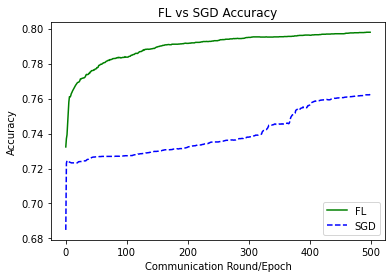

In [36]:
cr = np.arange(comms_round)
plt.plot(cr, global_acc_list, 'g', label = 'FL')
plt.plot(cr, sgd_acc_list, '--b', label = 'SGD')
plt.title('FL vs SGD Accuracy')
plt.xlabel('Communication Round/Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f'Plots/FL vs SGD Accuracy.png', dpi=150)
plt.show()

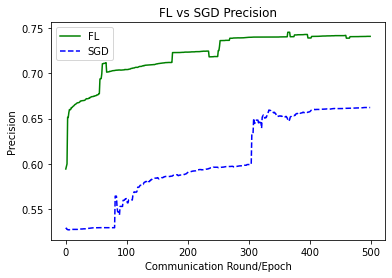

In [37]:
cr = np.arange(comms_round)
plt.plot(cr, global_precision_list, 'g', label = 'FL')
plt.plot(cr, sgd_precision_list, '--b', label = 'SGD')
plt.title('FL vs SGD Precision')
plt.xlabel('Communication Round/Epoch')
plt.ylabel('Precision')
plt.legend()
plt.savefig(f'Plots/FL vs SGD Precision.png', dpi=150)
plt.show()

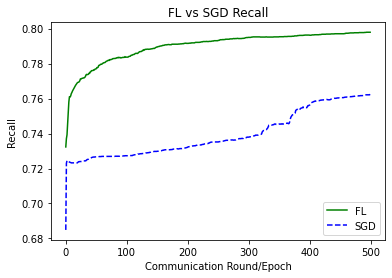

In [38]:
cr = np.arange(comms_round)
plt.plot(cr, global_recall_list, 'g', label = 'FL')
plt.plot(cr, sgd_recall_list, '--b', label = 'SGD')
plt.title('FL vs SGD Recall')
plt.xlabel('Communication Round/Epoch')
plt.ylabel('Recall')
plt.legend()
plt.savefig(f'Plots/FL vs SGD Recall.png', dpi=150)
plt.show()

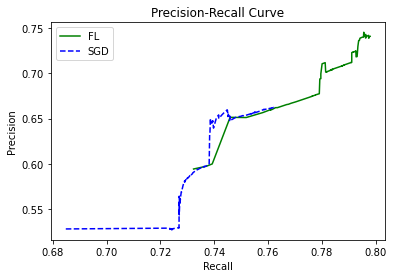

In [41]:
cr = np.arange(comms_round)
plt.plot(global_recall_list, global_precision_list, 'g', label = 'FL')
plt.plot(sgd_recall_list, sgd_precision_list, '--b', label = 'SGD')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.savefig(f'Plots/precision_recall_curve.png', dpi=150)
plt.show()

In [42]:
attack1 = pd.read_csv("attack1_test.csv")

X1 = attack1.iloc[:,:4].values
y1 = attack1.iloc[:,4:5].values

#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X1 = sc.fit_transform(X1)

lb = LabelBinarizer()
y1 = lb.fit_transform(y1)

y1_pred_fl = global_model.predict(X1)
y1_pred_sgd = sgd_model.predict(X1)

In [43]:
attack2 = pd.read_csv("attack2_test.csv")

X2 = attack2.iloc[:,:4].values
y2 = attack2.iloc[:,4:5].values

#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X2 = sc.fit_transform(X2)

lb = LabelBinarizer()
y2 = lb.fit_transform(y2)

y2_pred_fl = global_model.predict(X2)
y2_pred_sgd = sgd_model.predict(X2)

In [44]:
attack4 = pd.read_csv("attack3_test.csv")

X4 = attack4.iloc[:,:4].values
y4 = attack4.iloc[:,4:5].values

#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X4 = sc.fit_transform(X4)

lb = LabelBinarizer()
y4 = lb.fit_transform(y4)

y4_pred_fl = global_model.predict(X4)
y4_pred_sgd = sgd_model.predict(X4)

In [45]:
attack8 = pd.read_csv("attack4_test.csv")

X8 = attack8.iloc[:,:4].values
y8 = attack8.iloc[:,4:5].values

#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X8 = sc.fit_transform(X8)

lb = LabelBinarizer()
y8 = lb.fit_transform(y8)

y8_pred_fl = global_model.predict(X8)
y8_pred_sgd = sgd_model.predict(X8)

In [46]:
attack16 = pd.read_csv("attack5_test.csv")

X16 = attack16.iloc[:,:4].values
y16 = attack16.iloc[:,4:5].values

#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X16 = sc.fit_transform(X16)

lb = LabelBinarizer()
y16 = lb.fit_transform(y16)
y16 = y16.flatten()

y16_pred_fl = global_model.predict(X16)
y16_pred_sgd = sgd_model.predict(X16)

In [47]:
print("Precision for Attack 1:", precision_score(y1, tf.argmax(y1_pred_fl, axis=1), average='weighted', labels = [0,1,2,3,4,5]))
print("Precision for Attack 2:",precision_score(y2, tf.argmax(y2_pred_fl, axis=1), average='weighted', labels = [0,1,2,3,4,5]))
print("Precision for Attack 4:",precision_score(y4, tf.argmax(y4_pred_fl, axis=1), average='weighted', labels = [0,1,2,3,4,5]))
print("Precision for Attack 8:",precision_score(y8, tf.argmax(y8_pred_fl, axis=1), average='weighted', labels = [0,1,2,3,4,5]))
print("Precision for Attack 16:",precision_score(y16, tf.argmax(y16_pred_fl, axis=1), average='weighted', labels = [0,1,2,3,4,5]))

Precision for Attack 1: 0.9454545454545454
Precision for Attack 2: 0.6885714285714286
Precision for Attack 4: 0.4675324675324676
Precision for Attack 8: 0.8675324675324676
Precision for Attack 16: 0.9294117647058823


C:\Users\Intelligence\anaconda3\envs\federated\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
print("Precision for Attack 1:", precision_score(y1, tf.argmax(y1_pred_sgd, axis=1), average='weighted', labels = [0,1,2,3,4,5]))
print("Precision for Attack 2:",precision_score(y2, tf.argmax(y2_pred_sgd, axis=1), average='weighted', labels = [0,1,2,3,4,5]))
print("Precision for Attack 4:",precision_score(y4, tf.argmax(y4_pred_sgd, axis=1), average='weighted', labels = [0,1,2,3,4,5]))
print("Precision for Attack 8:",precision_score(y8, tf.argmax(y8_pred_sgd, axis=1), average='weighted', labels = [0,1,2,3,4,5]))
print("Precision for Attack 16:",precision_score(y16, tf.argmax(y16_pred_sgd, axis=1), average='weighted', labels = [0,1,2,3,4,5]))

Precision for Attack 1: 0.9454545454545454
Precision for Attack 2: 0.6916666666666665
Precision for Attack 4: 0.8675324675324676
Precision for Attack 8: 0.8615384615384616
Precision for Attack 16: 0.9373134328358209


In [49]:
print("Recall for Attack 1:", recall_score(y1, tf.argmax(y1_pred_fl, axis=1), average='weighted', labels = [0,1,2,3,4,5]))
print("Recall for Attack 2:",recall_score(y2, tf.argmax(y2_pred_fl, axis=1), average='weighted', labels = [0,1,2,3,4,5]))
print("Recall for Attack 4:",recall_score(y4, tf.argmax(y4_pred_fl, axis=1), average='weighted', labels = [0,1,2,3,4,5]))
print("Recall for Attack 8:",recall_score(y8, tf.argmax(y8_pred_fl, axis=1), average='weighted', labels = [0,1,2,3,4,5]))
print("Recall for Attack 16:",recall_score(y16, tf.argmax(y16_pred_fl, axis=1), average='weighted', labels = [0,1,2,3,4,5]))

Recall for Attack 1: 0.92
Recall for Attack 2: 0.63
Recall for Attack 4: 0.6
Recall for Attack 8: 0.63
Recall for Attack 16: 0.75


C:\Users\Intelligence\anaconda3\envs\federated\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
print("Recall for Attack 1:", recall_score(y1, tf.argmax(y1_pred_sgd, axis=1), average='weighted', labels = [0,1,2,3,4,5]))
print("Recall for Attack 2:",recall_score(y2, tf.argmax(y2_pred_sgd, axis=1), average='weighted', labels = [0,1,2,3,4,5]))
print("Recall for Attack 4:",recall_score(y4, tf.argmax(y4_pred_sgd, axis=1), average='weighted', labels = [0,1,2,3,4,5]))
print("Recall for Attack 8:",recall_score(y8, tf.argmax(y8_pred_sgd, axis=1), average='weighted', labels = [0,1,2,3,4,5]))
print("Recall for Attack 16:",recall_score(y16, tf.argmax(y16_pred_sgd, axis=1), average='weighted', labels = [0,1,2,3,4,5]))

Recall for Attack 1: 0.94
Recall for Attack 2: 0.67
Recall for Attack 4: 0.61
Recall for Attack 8: 0.63
Recall for Attack 16: 0.88
